# **Twitter Sentiment Project**

This is a kaggle challenge.

#Data Exploration and Pre-processing:

In [0]:
# Basic packages
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt


# Modeling, selection, and evaluation
#!pip install torch
#!pip install torchtext==0.2.3
from fastai.text import *
from fastai import *
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils.multiclass import unique_labels

## Data Exploration:

In [2]:
%matplotlib inline 

# Load csv data and store it in dataframe
url='https://raw.githubusercontent.com/cyu1221/MachineLearningCourse/master/Twitter%20Sentiments/Tweets.csv'
data = pd.read_csv(url)

# Preview the first 10 lines of the loaded data 
data.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


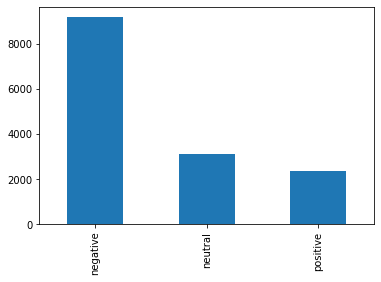

In [3]:
%matplotlib inline
data['airline_sentiment'].value_counts().plot(kind='bar') #plot data by sentiments

* The histograph above shows that there're more negative comments than other categories. It could be that people prefer to tweet about airlines when they are dissatisfied with the airline. 
* From the graph below, United airline, US Airway, and American airline have the most tweets. Virgin America has the least tweets. The total number of positive and neutral tweets are less than 50% of the total tweets per each airlines. However, this is not the case for 3 airlines, Delta, Southwest and Virgin airlines. One reason could be the limited number of tweets in this dataset while most tweets are negative. 
* If we were to study how Twitter users' sentiment on airlines, obtaining tweets from over a year at random time and settings would be more useful.

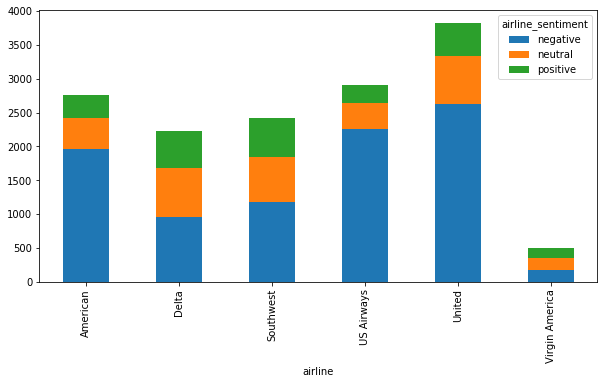

In [4]:
data.groupby(['airline', 'airline_sentiment']).size().unstack().plot(kind='bar',figsize=(10, 5),stacked=True)

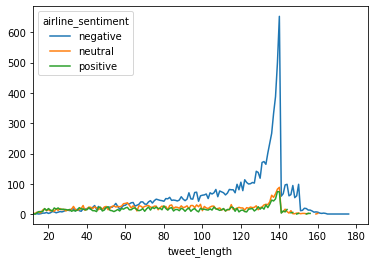

In [5]:
data['tweet_length'] = data['text'].apply(len)
data.groupby(['tweet_length', 'airline_sentiment']).size().unstack().plot(kind='line', stacked=False)

## Train Test Split:

Make sure we are only analysing English language:

In [0]:
def clean_ascii(text):
    # function to remove non-ASCII chars from data
    return ''.join(i for i in text if ord(i) < 128)

Train test split: 30% is testing set. 70% is training set.

In [7]:
df = data[['airline_sentiment', 'text']]
train,test = train_test_split(df, test_size=0.30, random_state=42)
train['text'] = train['text'].apply(clean_ascii)
train.head(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,airline_sentiment,text
7717,neutral,@JetBlue Re: Flight 8088 SXM&gt;JFK what time ...
13854,negative,@AmericanAir why are you still selling tickets...
11719,negative,@USAirways I have now called 12 times in the l...
239,positive,@VirginAmerica sounds like fun !
8582,neutral,@JetBlue Statement on #Lufthansa Incentive Off...


In [8]:
print(len(train),len(test))

10248 4392


# ULFMiT:


This notebook utilizes ULMFit as implemented in the fastai GitHub repository. 

1. Below is the TextLMDataBunch that returns a "Databunch" type of object and helps assembling the raw data to be suitable for NLP. The Databunch code includes text manipulation code from the ground up and tokenization. We can take advantage of the  transfer learning functionality of ULMFit functions. Source: https://docs.fast.ai/text.data.html#Quickly-assemble-your-data

2. View tokenization rules here:https://docs.fast.ai/text.transform.html#Rules

In [9]:
# language model: use 10% as validation set. Language model is trained to guess what the next word is inside a flow of words. 
data_lm = TextLMDataBunch.from_df(train_df = train[:-1024], valid_df=test[-1024:], path="")
data_lm.show_batch()
# Save the language and classifier model data
data_lm.save('data_lm.pkl')
print(len(data_lm.train_ds))

idx,text
0,"i 'm willing to wait on hold , but that 's not an option . xxbos @virginamerica sounds like fun ! xxbos @jetblue xxmaj statement on # xxmaj lufthansa xxmaj incentive xxmaj offer - xxmaj xxunk http : / / t.co / xxunk xxbos @americanair xxmaj thx ! i hope so . xxup iah to xxup dfw to xxup okc has turned out to be a xxup long trip today"
1,"ground staff , it has n't even been taken off the plane yet ! xxbos @usairways i am following you now xxbos @jetblue after my second call to customer service and the xxunk person i talked to , an amazing rep fixed it in about 5 mins ! :) # xxunk xxbos @southwestair so for an extra luggage , it cost $ 75 xxrep 4 ? xxbos @usairways xxmaj will"
2,"10 flights have been delayed . xxmaj huge mistake on my part . xxmaj do n't fly united xxbos @jetblue anything for you . # flyfi http : / / t.co / xxunk xxbos @united even so , change could not be made xxunk instructed to call an xxunk maybe the xxunk should allow agents 2 link passengers ! xxbos @americanair great , thanks ! xxbos @jetblue tells me $"
3,failure in 2015 # unitedairlines xxbos @jetblue 's xxup ceo xxmaj battles to xxmaj appease xxmaj passengers and xxmaj wall xxmaj street - http : / / t.co / e5naxbue4s http : / / t.co / xxunk xxbos @united what 's the best way to get your tickets ? xxmaj print off at home or go to check in desk ? xxbos @united i would take the $ 500 voucher
4,yesterday . i wonder how quickly flight attendants are notified . xxbos @americanair i dmed xxbos @jetblue what is the deal with flt xxunk today ? xxmaj departure keeps changing . xxmaj when is it going why is it so xxmaj late xxmaj flight ? xxbos xxmaj yes but i will nvr fly w / @usairways i missed my con flight bc of a xxunk on xxup xxunk xxmaj could


9224


see chunks of texts in lines

In [10]:
x,y = next(iter(data_lm.train_dl))
example = x[:15,:15].cpu()
texts = pd.DataFrame([data_lm.train_ds.vocab.textify(l).split(' ') for l in example])
texts

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,and,i,have,to,work,tomorrow,.,xxbos,@southwestair,i,'m,trying,to,get,home
1,do,.,i,appreciate,the,response,.,xxbos,@southwestair,xxunk,over,two,hours,now,.
2,130,paid,&,&,confirmed,flight,will,now,cost,me,$,xxunk,xxup,cash,xxup
3,you,offered,for,xxup,xxunk,xxup,the,#,xxup,of,xxup,seats,xxup,on,xxup
4,n't,see,my,father,xxunk,they,put,him,in,a,xxunk,xxbos,@united,.,epic
5,i,can,talk,to,?,xxbos,@usairways,they,call,weather,an,act,of,xxmaj,god
6,@united,xxmaj,apart,from,being,on,hold,for,over,2,hours,and,having,talked,to
7,help,?,!,xxbos,@americanair,i,have,been,rebooked,for,the,7,am,flight,.
8,me,to,buy,the,xxunk,tickets,xxbos,@jetblue,figured,it,out,4,flight,xxunk,.
9,bad,weather,",",but,closes,down,customer,relations,center,to,process,refunds,for,xxmaj,cancelled


See the number of vocabs:

In [11]:
data_lm.vocab.itos[:10]
print(len(data_lm.vocab.itos))

5008


Define Learning Object:
See below for the architecture of AWD_LSTM


In [12]:
learn_AWD = language_model_learner(data_lm,  AWD_LSTM, drop_mult=0.5)

list(learn_AWD.model.children())

[AWD_LSTM(
   (encoder): Embedding(5008, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(5008, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1152, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1152, 1152, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1152, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=5008, bias=True)
   (output_dp): RNNDropout()
 )]

## Learning Rate: 

* The learning rate finder train the model over the duration of 1 epoch at a very low learning rate to begin with, and gradually increasing it over time, multiplying it by a given factor at each mini-batch, until it reaches 1, whilst recording the loss at each timestep.
* source function for lr_find: https://github.com/fastai/fastai/blob/050080be574cb1260462bbd03e9600e43e7a54b1/fastai/train.py#L23
* recorder.plot is to show the graph.

In [13]:
learn_AWD.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


According to the graph below, the loss gradually decrease to a minimum before it drastically increase. We could set learning rate at a point that is about a factor of 10 lower than the minimum.

Min numerical gradient: 4.79E-02
Min loss divided by 10: 6.31E-02


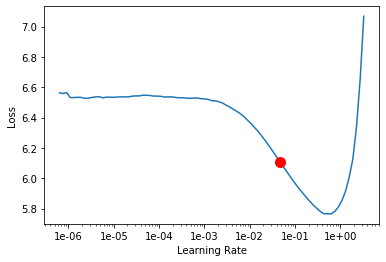

In [14]:
learn_AWD.recorder.plot(suggestion=True)

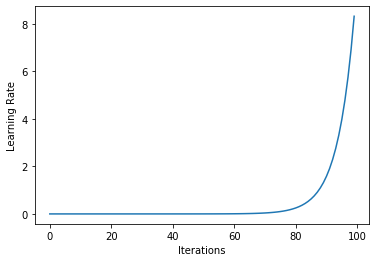

In [15]:
learn_AWD.recorder.plot_lr()

In [0]:
#for GPU mixed precision can be as simple as adding one line of code or enabling a single environment variable, to speed up process
learn_AWD = learn_AWD.to_fp16(clip=0.1)

## Slanted Triangular Learning Rates:

In [17]:
learn_AWD.fit_one_cycle(1, max_lr=1e-3, moms=(0.8,0.7))
learn_AWD.save('fit_head')

epoch,train_loss,valid_loss,accuracy,time
0,6.124083,5.754877,0.162240,00:04


Slated triangular learning rates from ULFMiT. According to the plot below, cut occurs around iteration 15.

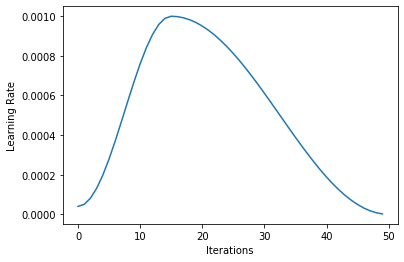

In [18]:
learn_AWD.recorder.plot_lr()

To train the language model during fine-tuning, we unfreeze all the layers and then perform training for a reasonable time until we obtain a low enough validation loss. Since the vocab dictionary is relatively small, we can see validation loss decreasing to a local minimum quickly.

In [19]:
learn_AWD.unfreeze()
learn_AWD.fit_one_cycle(cyc_len=10, max_lr=1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,5.076209,4.564798,0.222656,00:06
1,4.533126,4.010619,0.263691,00:06
2,4.138216,3.808228,0.279315,00:06
3,3.839760,3.730129,0.287202,00:06
4,3.559006,3.718160,0.290327,00:06
5,3.301450,3.740975,0.287686,00:06
6,3.059934,3.779738,0.287537,00:06
7,2.855597,3.835257,0.287165,00:06
8,2.715097,3.867556,0.284524,00:06
9,2.641247,3.876323,0.284896,00:06


In [0]:
learn_AWD.save('fine_tuned')
# Save the fine-tuned encoder
learn_AWD.save_encoder('fit_enc')

## Classifier:

In [21]:
# load the data for the forward classifier model using the same language model vocabular so that it'll be able to load the encoder 'fit_enc' created above
data_clas = (TextList.from_df(train, vocab=data_lm.train_ds.vocab,cols='text')
                          .split_by_rand_pct(0.1, seed=42) 
                          .label_from_df(cols='airline_sentiment')
                          .databunch(bs=128))

data_clas.save('data_clas.pkl')
data_clas.show_batch()

text,target
xxbos @united xxup where xxup is xxup my xxup fucking xxup bag ? ! ? ! xxmaj where the fuck is my fucking bag ? ? ? xxup tell xxup me xxup now xxup or xxup give xxup me a xxup number xxup to xxup call a xxup human . xxup san68059 m,negative
xxbos @southwestair xxmaj the xxmaj fact xxmaj that u xxmaj see xxmaj black xxmaj history xxmaj month 12 xxmaj months a xxmaj year xxmaj is xxmaj xxunk ! xxmaj we xxup will xxup be xxmaj an xxmaj xxunk xxmaj base xxmaj for xxmaj xxunk xxmaj like u xxmaj in xxmaj future !,positive
"xxbos @united xxmaj hi , i m flying xxup sfo - xxup lax - xxup xxunk - xxup xxunk . xxmaj my connecting time in xxup lax is xxunk m . xxmaj is it enough time ? xxmaj do i have to collect my bag and recheck on xxup xxunk ?",neutral
"xxbos @usairways 4 segments , 4 / 4 delayed . xxmaj xxunk > xxup xxunk . xxup xxunk > xxup jan . xxup jan > xxup xxunk . xxup xxunk > xxup xxunk . xxmaj my year off from flying with you guys was the way to go .",negative
xxbos @americanair xxmaj aww xxmaj thanks xxup aa .. xxup dfw was on xxup gma up here this xxup am .. so i understand .. xxmaj btw xxup a.a is my xxmaj airline when i m able to trv .. xxmaj love you guys . : ),positive


In [0]:

learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn_clas.load_encoder('fit_enc')
learn_clas.freeze()

In [23]:
learn_clas.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


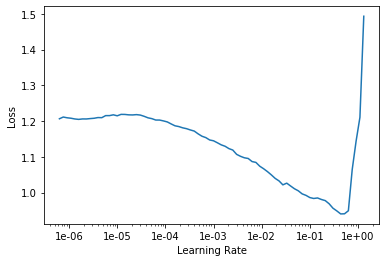

In [24]:
learn_clas.recorder.plot()

## Gradually Unfreezing:

* Gradually unfreeze layers and then running an epoch each time, in accordance with the suggestions in the ULMFiT paper to obtain a higher accurancy.
* The paper proposed to gradually unfreeze the model starting from the last layer and fine-tune all unfrozen layers in one epoch. The latter a layer is, the least memory it has compared to other layers. They later freeze the next lower layer and repeat the fine-tuning process until convergence at last iteration.
* We use slice() to apply different lr for different groups 

In [25]:
lr=2e-2
learn_clas.fit_one_cycle(1, lr, moms=(0.8,0.7), wd=0.1)
learn_clas.save('first')

epoch,train_loss,valid_loss,accuracy,time
0,0.699316,0.587548,0.750977,00:06


In [26]:
lr/=2
learn_clas.freeze_to(-2)
learn_clas.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)
learn_clas.save('second')

epoch,train_loss,valid_loss,accuracy,time
0,0.637686,0.550358,0.790039,00:06


In [27]:
lr/=2
learn_clas.freeze_to(-3)
learn_clas.fit_one_cycle(1, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.573802,0.515403,0.797852,00:06


In [28]:
lr/=5
learn_clas.unfreeze()
learn_clas.fit_one_cycle(4, slice(lr/(2.6**4),lr), moms=(0.8,0.7), wd=0.1)

epoch,train_loss,valid_loss,accuracy,time
0,0.503976,0.504744,0.793945,00:06
1,0.490098,0.495602,0.805664,00:06
2,0.472205,0.492248,0.809570,00:06
3,0.446772,0.494754,0.805664,00:06


## Predictions:

*  Cross-tabulate the predictions for each class:


In [29]:
preds_fwd, targets_fwd = learn_clas.get_preds()
predictions_fwd = np.argmax(preds_fwd, axis=1)
pd.crosstab(predictions_fwd, targets_fwd)

col_0,0,1,2
row_0,,,
0,574,64,28
1,42,128,17
2,19,29,123


#Bidirectional Language Model:

In order to apply Bidirectional language model, We'll reverse the words in tweets  form training set. We'll follow the exact same steps we took for language model (data_lm) and language model learner (learn_AWD). 


*   load data from pre-saved 'data_lm.pkl' and reverse it and save it into 'data_lm_back.pkl'
*   apply language model, learning rate finder and train 1 epoch.



## Reverse:

In [30]:
##recall: # language model 
##data_lm = TextLMDataBunch.from_df(train_df = train, valid_df = test, path="")
##Save the language and classifier model data
##data_lm.save('data_lm.pkl')

data_lm_back = load_data('/content/','data_lm.pkl',  backwards=True)
# Save the language and classifier model data
data_lm_back.save('data_lm_back.pkl')
print(len(data_lm_back.train_ds))

9224


## Learning Rate:

In [31]:
learn_AWD_back=language_model_learner(data_lm_back,  AWD_LSTM, drop_mult=0.5)
learn_AWD_back.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.92E-02
Min loss divided by 10: 5.25E-02


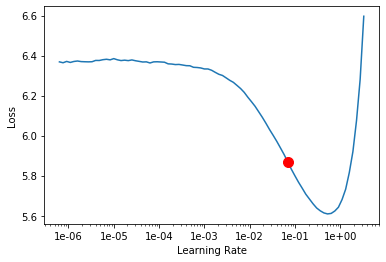

In [32]:
learn_AWD_back.recorder.plot(suggestion=True)

In [33]:
learn_AWD_back.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
learn_AWD_back.save('fit_head')

epoch,train_loss,valid_loss,accuracy,time
0,4.853065,4.179204,0.287351,00:06


epoch,train_loss,valid_loss,accuracy,time
0,4.186066,4.003013,0.300112,00:06
1,4.025865,3.837646,0.312649,00:06
2,3.871439,3.736770,0.322433,00:06
3,3.714166,3.686411,0.327641,00:06
4,3.554218,3.657007,0.329650,00:06
5,3.410316,3.649693,0.331176,00:06
6,3.276669,3.654272,0.330729,00:06
7,3.171992,3.665735,0.331176,00:06
8,3.094368,3.670538,0.330990,00:06
9,3.075546,3.669675,0.331362,00:06


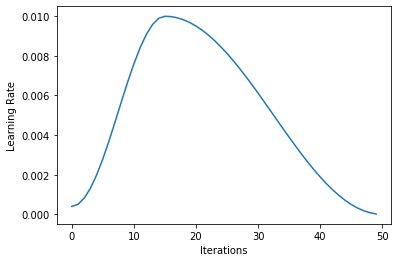

In [34]:
learn_AWD_back.recorder.plot_lr()
learn_AWD_back.unfreeze()
learn_AWD_back.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

In [0]:
learn_AWD_back.save('fine_tuned')
# Save the fine-tuned encoder
learn_AWD_back.save_encoder('fit_enc')

## Classifier:

In [36]:
# recall: we loaded the data for the forward classifier model using the same language model vocabular so that it'll be able to load the encoder 'fit_enc' created above

data_clas_back=load_data('/content/', 'data_clas.pkl', backwards=True)
data_clas_back.save('bw_data_clas_back.pkl')
data_clas_back.show_batch()

text,target
m san68059 xxup . human xxup a call xxup to xxup number xxup a me xxup give xxup or xxup now xxup me xxup tell xxup ? ? ? bag fucking my is fuck the where xxmaj ! ? ! ? bag xxup fucking xxup my xxup is xxup where xxup @united xxbos,negative
"? xxunk xxup on recheck and bag my collect to have i do xxmaj ? time enough it is xxmaj . m xxunk is lax xxup in time connecting my xxmaj . xxunk xxup - xxunk xxup - lax xxup - sfo xxup flying m i , hi xxmaj @united xxbos",neutral
) : . guys you love xxmaj .. trv to able m i when airline xxmaj my is a.a xxup btw xxmaj .. understand i so .. am xxup this here up gma xxup on was dfw xxup .. aa xxup thanks xxmaj aww xxmaj @americanair xxbos,positive
) : . guys you love xxmaj .. trv to able m i when airline xxmaj my is a.a xxup btw xxmaj .. understand i so .. am xxup this here up gma xxup on was dfw xxup .. aa xxup thanks xxmaj aww xxmaj @americanair xxbos,positive
! bag no still xxmaj . iah xxup to back then and dfw xxup - iah xxup to went bag today xxmaj . iah xxup to went bag xxmaj . aus xxup - dfw xxup - tpa xxup fron yesterday flight a took xxmaj @americanair xxbos,negative


In [0]:
learn_clas_back = text_classifier_learner(data_clas_back, AWD_LSTM, drop_mult=0.5)

In [38]:
learn_clas_back.load_encoder('fit_enc')
learn_clas_back.freeze()
learn_clas_back.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))
learn_clas_back.save('first')

epoch,train_loss,valid_loss,accuracy,time
0,0.700045,0.590025,0.759766,00:07


In [39]:
learn_clas_back.freeze_to(-2)
learn_clas_back.fit_one_cycle(1,slice(1e-2/(2.6**4),1e-2),moms=(0.8, 0.7) )
learn_clas_back.save('second')

epoch,train_loss,valid_loss,accuracy,time
0,0.627393,0.549011,0.784180,00:07


In [40]:
learn_clas_back.freeze_to(-3)

learn_clas_back.fit_one_cycle(1,slice(5e-3/(2.6**4),5e-3),moms=(0.8,0.7) )



epoch,train_loss,valid_loss,accuracy,time
0,0.560708,0.521814,0.795898,00:07


In [41]:
learn_clas_back.unfreeze()
learn_clas_back.fit_one_cycle(3,slice(1e-3/(2.6**4),1e-3),moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.501805,0.506121,0.801758,00:08
1,0.478856,0.491060,0.803711,00:08
2,0.461929,0.490978,0.801758,00:08


## Predictions:

In [42]:
preds_back,targets_back=learn_clas_back.get_preds()
predictions_back=np.argmax(preds_back,axis=1)
pd.crosstab(predictions_back,targets_back)

col_0,0,1,2
row_0,,,
0,581,76,34
1,40,123,17
2,14,22,117


## Ensemble Classifier:

As we seen below, ensemble method increased accurancy by 0.01.

In [0]:
def f1score(y_true, y_preds):
  f1=sklearn.metrics.f1_score(y_true,y_preds, 
                                labels=None, pos_label=1, average='weighted',sample_weight=None, zero_division='warn')
  return f1

In [44]:
# get combined(mean) predictions
ensemble_preds = (preds_fwd + preds_back)/2
# get combined(mean) accuracy on validation set
print('Ensemble classifier results (validation set): \nValidation accuracy: {:.4f}, Validation error rate: {:.4f}'.format(accuracy(ensemble_preds, targets_fwd), error_rate(ensemble_preds, targets_fwd)))
print('FWD classifier results (validation set): \nValidation accuracy: {:.4f}, Validation error rate: {:.4f}'.format(accuracy(preds_fwd, targets_fwd), error_rate(preds_fwd, targets_fwd)))
print('BACK classifier results (validation set): \nValidation accuracy: {:.4f}, Validation error rate: {:.4f}'.format(accuracy(preds_back, targets_back), error_rate(preds_back, targets_back)))

Ensemble classifier results (validation set): 
Validation accuracy: 0.8135, Validation error rate: 0.1865
FWD classifier results (validation set): 
Validation accuracy: 0.8057, Validation error rate: 0.1943
BACK classifier results (validation set): 
Validation accuracy: 0.8018, Validation error rate: 0.1982


# Evaulate Performance on test set:


*   Apply the learner's predict method to produce our prediction (using learn_clas and learn_clas_back.
*   Calculate F1 score
*   Build Confusion Matrix

In [45]:
test['pred_sentiment_fwd'] = test['text'].apply(lambda row: str(learn_clas.predict(row)[0]))
print("Test Accuracy: ", accuracy_score(test['airline_sentiment'], test['pred_sentiment_fwd']))

Test Accuracy:  0.8228597449908925


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [46]:
import sklearn
f1_fwd=sklearn.metrics.f1_score(test['airline_sentiment'], test['pred_sentiment_fwd'], 
                                labels=None, pos_label=1, average='weighted',sample_weight=None, zero_division='warn')
print("F1-Score: ",f1_fwd)

F1-Score:  0.8177883314418077


In [0]:
# Confusion matrix plotting adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
   # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

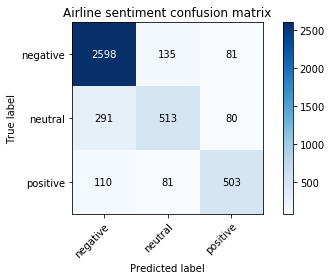

In [48]:
plot_confusion_matrix(test['airline_sentiment'], test['pred_sentiment_fwd'], classes=['negative', 'neutral', 'positive'], title='Airline sentiment confusion matrix')
plt.show()

In [51]:

test['text_reverse'] =  test.text.str.split().apply(lambda x: ' '.join(x[::-1])) #reverse the words

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [52]:
test['pred_sentiment_back']=test['text_reverse'].apply(lambda row:str(learn_clas_back.predict(row)[0]))
print("Test Accuracy: ",accuracy_score(test['airline_sentiment'],test['pred_sentiment_back']))

Test Accuracy:  0.808287795992714


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [53]:
import sklearn
f1_back=sklearn.metrics.f1_score(test['airline_sentiment'], test['pred_sentiment_back'], 
                                labels=None, pos_label=1, average='weighted',sample_weight=None, zero_division='warn')
print("F1-Score: ",f1_fwd)

F1-Score:  0.8177883314418077


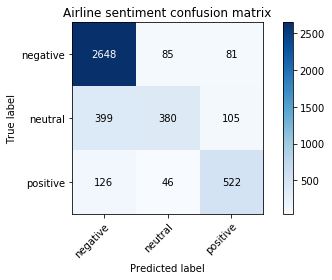

In [54]:
plot_confusion_matrix(test['airline_sentiment'], test['pred_sentiment_back'], classes=['negative', 'neutral', 'positive'], title='Airline sentiment confusion matrix')
plt.show()